# Introduction
# Problem Statement
Using the data obtained during the regular season, how frequently can we correctly predict the outcomes of NCAA March Madness tournament games? What features and models perform the best when trying to predict the outcome? 

# Starting Simple

Usually its a good idea to start simple. One of the most basic models that could be created for the NCAA Tournament would be to base the predictions solely on the seeds assigned to them based on their position in the bracket. There are four divisions in the NCAA tournament, each with 16 teams that range in seeding from 1 to 16. Then, each team is paired with another based on their seeding; 1 pairs with 16, 2 with 15, and so on, until 8 pairs with 9. The 1 seeds are considered the strongest teams while the 16 seeds are considered the weakest (in fact, no 16 seed had managed to win a single tournament game against a 1 seed until 2018, almost 80 years since the tournament began). 

There is also a considerable about of information encoded in the seed value, which is based on national rankings, polls, W-L records, and general concensus at the time. Therefore we should expect the seed value alone to have considerable predictive power. We may run into problems when trying to predict teams with the same seed but the model is too simple to fix this for now. 

First, we import needed modules and load data. I found this dataset on Kaggle.

In [1]:
import numpy as np 
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd 
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import log_loss
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GroupKFold
from sklearn.metrics import log_loss
from sklearn import preprocessing
from sklearn.inspection import permutation_importance 
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from mlxtend.classifier import StackingCVClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge

output_file_name = 'NCAA_Tourney_2020'

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [2]:
#Load Data
data_frames = {}
for dirname, _, filenames in os.walk('Data\MDataFiles_Stage1\.'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        data_frames[filename[:-4]] = pd.read_csv(os.path.join(dirname, filename),encoding = 'ISO-8859-1')

Data\MDataFiles_Stage1\.\Cities.csv
Data\MDataFiles_Stage1\.\Conferences.csv
Data\MDataFiles_Stage1\.\MConferenceTourneyGames.csv
Data\MDataFiles_Stage1\.\MGameCities.csv
Data\MDataFiles_Stage1\.\MMasseyOrdinals.csv
Data\MDataFiles_Stage1\.\MNCAATourneyCompactResults.csv
Data\MDataFiles_Stage1\.\MNCAATourneyDetailedResults.csv
Data\MDataFiles_Stage1\.\MNCAATourneySeedRoundSlots.csv
Data\MDataFiles_Stage1\.\MNCAATourneySeeds.csv
Data\MDataFiles_Stage1\.\MNCAATourneySlots.csv
Data\MDataFiles_Stage1\.\MPlayers.csv
Data\MDataFiles_Stage1\.\MRegularSeasonCompactResults.csv
Data\MDataFiles_Stage1\.\MRegularSeasonDetailedResults.csv
Data\MDataFiles_Stage1\.\MSampleSubmissionStage1_2020.csv
Data\MDataFiles_Stage1\.\MSeasons.csv
Data\MDataFiles_Stage1\.\MSecondaryTourneyCompactResults.csv
Data\MDataFiles_Stage1\.\MSecondaryTourneyTeams.csv
Data\MDataFiles_Stage1\.\MTeamCoaches.csv
Data\MDataFiles_Stage1\.\MTeamConferences.csv
Data\MDataFiles_Stage1\.\MTeams.csv
Data\MDataFiles_Stage1\.\MTeamSpe

In [3]:
data_frames.keys()

dict_keys(['Cities', 'Conferences', 'MConferenceTourneyGames', 'MGameCities', 'MMasseyOrdinals', 'MNCAATourneyCompactResults', 'MNCAATourneyDetailedResults', 'MNCAATourneySeedRoundSlots', 'MNCAATourneySeeds', 'MNCAATourneySlots', 'MPlayers', 'MRegularSeasonCompactResults', 'MRegularSeasonDetailedResults', 'MSampleSubmissionStage1_2020', 'MSeasons', 'MSecondaryTourneyCompactResults', 'MSecondaryTourneyTeams', 'MTeamCoaches', 'MTeamConferences', 'MTeams', 'MTeamSpellings'])

## Load Seed Data

First we will need to load the tournament seeds. There are four seeds of each number for each season (four 1 seeds, four 2 seeds, ..., four 16 seeds). 

In [4]:
TourneySeeds = pd.DataFrame(data_frames['MNCAATourneySeeds'].copy())
TourneySeeds['SeedN'] = TourneySeeds['Seed'].apply(lambda x: int(x[1:3]))
TourneySeeds.drop('Seed',axis=1,inplace=True)
TourneySeeds

,Season,TeamID,SeedN
0,1985,1207,1
1,1985,1210,2
2,1985,1228,3
3,1985,1260,4
4,1985,1374,5
...,...,...,...
2281,2019,1332,12
2282,2019,1414,13
2283,2019,1330,14
2284,2019,1159,15


## Build Training Dataset

Next, we need a dataset to train the model. We can do this by pulling historical tournament results. We will organize our forecasts with the following ID: Season_Team1ID_Team2ID where Team1ID < Team2ID. 

In [6]:
TourneyCompactResults = pd.DataFrame(data_frames['MNCAATourneyCompactResults'].copy())
TourneyCompactResults['TeamID1'] = np.minimum(TourneyCompactResults['WTeamID'],TourneyCompactResults['LTeamID'])
TourneyCompactResults['TeamID2'] = np.maximum(TourneyCompactResults['WTeamID'],TourneyCompactResults['LTeamID'])
TourneyCompactResults['result'] = np.where(TourneyCompactResults['WTeamID']==TourneyCompactResults['TeamID1'],1,0)
TourneyCompactResults['result_differential'] = np.where(TourneyCompactResults['WTeamID']==TourneyCompactResults['TeamID1'],TourneyCompactResults['WScore'] - TourneyCompactResults['LScore'],TourneyCompactResults['LScore'] - TourneyCompactResults['WScore'])
TourneyCompactResults['ID'] = TourneyCompactResults['Season'].astype(str)+ '_' +TourneyCompactResults['TeamID1'].astype(str)+ '_' +TourneyCompactResults['TeamID2'].astype(str)
TourneyCompactResults_Seed = TourneyCompactResults

TourneyCompactResults_Seed = (TourneyCompactResults_Seed
                             .merge(TourneySeeds,left_on=['Season','TeamID1'],right_on=['Season','TeamID'],how='left')
                             .drop('TeamID',axis=1)
                             .merge(TourneySeeds,left_on=['Season','TeamID2'],right_on=['Season','TeamID'],how='left')
                             .drop('TeamID',axis=1)
                             )

TourneyCompactResults_Seed['Seed_Differential'] = TourneyCompactResults_Seed['SeedN_x'] - TourneyCompactResults_Seed['SeedN_y'] 
# TourneyCompactResults_Seed['Seed_Differential_Norm'] = (TourneyCompactResults_Seed['SeedN_x'] - TourneyCompactResults_Seed['SeedN_y']) / np.sqrt(np.minimum(TourneyCompactResults_Seed['SeedN_x'], TourneyCompactResults_Seed['SeedN_y']))

TourneyCompactResults_Seed

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,TeamID1,TeamID2,result,result_differential,ID,SeedN_x,SeedN_y,Seed_Differential
0,1985,136,1116,63,1234,54,N,0,1116,1234,1,9,1985_1116_1234,9,8,1
1,1985,136,1120,59,1345,58,N,0,1120,1345,1,1,1985_1120_1345,11,6,5
2,1985,136,1207,68,1250,43,N,0,1207,1250,1,25,1985_1207_1250,1,16,-15
3,1985,136,1229,58,1425,55,N,0,1229,1425,1,3,1985_1229_1425,9,8,1
4,1985,136,1242,49,1325,38,N,0,1242,1325,1,11,1985_1242_1325,3,14,-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2246,2019,146,1120,77,1246,71,N,1,1120,1246,1,6,2019_1120_1246,5,2,3
2247,2019,146,1277,68,1181,67,N,0,1181,1277,0,-1,2019_1181_1277,1,2,-1
2248,2019,152,1403,61,1277,51,N,0,1277,1403,0,-10,2019_1277_1403,2,3,-1
2249,2019,152,1438,63,1120,62,N,0,1120,1438,0,-1,2019_1120_1438,5,1,4


In [7]:
TourneyCompactResults_Seed = TourneyCompactResults_Seed[TourneyCompactResults_Seed['Season'] >= 2003][TourneyCompactResults_Seed['Season'] <= 2018]
TourneyCompactResults_Seed_Train = TourneyCompactResults_Seed[TourneyCompactResults_Seed['Season'] >= 2003][TourneyCompactResults_Seed['Season'] <= 2014]
TourneyCompactResults_Seed_Test = TourneyCompactResults_Seed[TourneyCompactResults_Seed['Season'] >= 2015][TourneyCompactResults_Seed['Season'] <= 2018]
TourneyCompactResults_Seed_Train = TourneyCompactResults_Seed_Train.fillna(0)
TourneyCompactResults_Seed_Train

C:\Users\Zack\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
C:\Users\Zack\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,TeamID1,TeamID2,result,result_differential,ID,SeedN_x,SeedN_y,Seed_Differential
1136,2003,134,1421,92,1411,84,N,1,1411,1421,0,-8,2003_1411_1421,16,16,0
1137,2003,136,1112,80,1436,51,N,0,1112,1436,1,29,2003_1112_1436,1,16,-15
1138,2003,136,1113,84,1272,71,N,0,1113,1272,1,13,2003_1113_1272,10,7,3
1139,2003,136,1141,79,1166,73,N,0,1141,1166,1,6,2003_1141_1166,11,6,5
1140,2003,136,1143,76,1301,74,N,1,1143,1301,1,2,2003_1143_1301,8,9,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1911,2014,146,1163,60,1277,54,N,0,1163,1277,1,6,2014_1163_1277,7,4,3
1912,2014,146,1246,75,1276,72,N,0,1246,1276,1,3,2014_1246_1276,8,2,6
1913,2014,152,1163,63,1196,53,N,0,1163,1196,1,10,2014_1163_1196,7,1,6
1914,2014,152,1246,74,1458,73,N,0,1246,1458,1,1,2014_1246_1458,8,2,6


In [14]:
feature_list_seed = ['SeedN_x', 'Seed_Differential']

In [15]:
explore_df_seed = TourneyCompactResults_Seed_Train.loc[:, feature_list_seed + ['Season', 'result']]

# explore_df['Off/Def'] = explore_df['Diff_TS%'] + explore_df['Diff_ORB%']

# explore_dfs = pd.DataFrame(preprocessing.StandardScaler().fit_transform(explore_df), columns=explore_df.columns)

explore_df_seed

,SeedN_x,Seed_Differential,Season,result
1136,16,0,2003,0
1137,1,-15,2003,1
1138,10,3,2003,1
1139,11,5,2003,1
1140,8,-1,2003,1
...,...,...,...,...
1911,7,3,2014,1
1912,8,6,2014,1
1913,7,6,2014,1
1914,8,6,2014,1


C:\Users\Zack\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\Zack\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


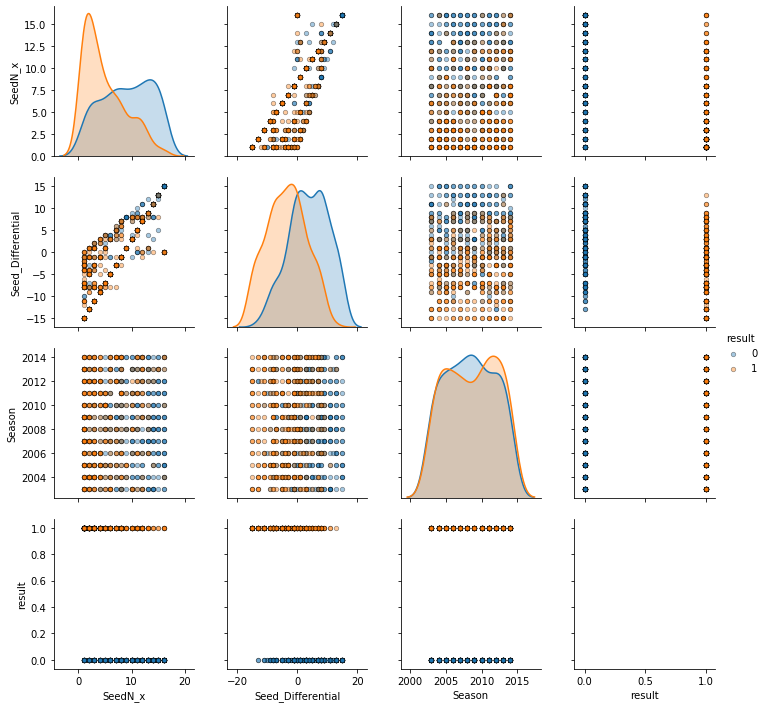

In [16]:
sns.pairplot(explore_df_seed, hue='result', plot_kws = {'alpha': 0.4, 's': 20, 'edgecolor': 'k'})
plt.show()

In [17]:
x_seed = TourneyCompactResults_Seed_Train.loc[:, feature_list_seed]
xs_seed = pd.DataFrame(preprocessing.StandardScaler().fit_transform(x_seed), columns = x_seed.columns)
y_seed = TourneyCompactResults_Seed_Train[['result']]
x_train_seed, x_test_seed, y_train_seed, y_test_seed = train_test_split(xs_seed, y_seed, test_size=0.3, stratify = TourneyCompactResults_Seed_Train['Season'])
x_train_seed

,SeedN_x,Seed_Differential
517,-0.854417,-1.501424
408,-1.064851,-1.768132
648,1.881227,-0.034535
426,0.829057,1.032293
120,-0.854417,-0.567949
...,...,...
757,-1.275285,-0.968010
76,-1.275285,-2.034839
4,0.197754,-0.167889
525,-1.275285,-2.034839


## Logistic Regression

One of the simplest models for this sort of classification is logistic regression. We will run for different alphas to determine the best alpha and best neg_log_loss produced. We will be scoring our models against negative log loss. Negative log loss for binary event $x_i$ is calculated as:
\begin{equation*}
logLoss_i =
 \begin{cases} 
      -log(p_i) & x_i = 0 \\
      -log(1-p_i) & x_i = 1
   \end{cases}
\end{equation*}
Where $p_i$ is the predicted probability for event $x_i$.

In [19]:
for alpha in [0.001,0.01,0.1,1,10,100,1000]:
    
    lr = LogisticRegression(solver='lbfgs',C=alpha,random_state=42,max_iter=500)
    score = cross_val_score(lr, xs_seed.loc[:, feature_list_seed], y_seed.values.ravel(), cv=5, scoring='neg_log_loss')
    print(alpha, np.mean(score))
    # 0.5538911848914796

0.001 -0.6456680656174483
0.01 -0.5732845388097803
0.1 -0.5579348211638551
1 -0.5576934704160046
10 -0.5577780932073905
100 -0.5577884062135009
1000 -0.5577894572637334


Based on the KDE in the pairplot above, seed and seed differential look to be highly correlated with each other. We may capture all the information we need in seed differential alone.

In [20]:
feature_list_seed = ['Seed_Differential']

In [21]:
for alpha in [0.001,0.01,0.1,1,10,100,1000]:
    
    lr = LogisticRegression(solver='lbfgs',C=alpha,random_state=42,max_iter=500)
    score = cross_val_score(lr, xs_seed.loc[:, feature_list_seed], y_seed.values.ravel(), cv=5, scoring='neg_log_loss')
    print(alpha, np.mean(score))
    # 0.5538911848914796

0.001 -0.6624307262489986
0.01 -0.5859875389173931
0.1 -0.559623551411246
1 -0.5589497697197073
10 -0.5590006968106639
100 -0.5590074303362734
1000 -0.5590081204528926


We seem to lose only a minor amount of accuracy while removing a variable from our list. Additionally, cross validation with the different $\alpha$ reveals that $\alpha>=.1$ works well, with $\alpha=1$ being optimal in this case. This should work well enough to give us a baseline model to build on.

## Adding More Data

Before we can start adding more features to try to improve the model, we will need to some work with the MRegularSeasonDetailedResults table that we have. The data includes one row for every regular season game from 2003 to 2019, and denotes the teams involved in the game by the winning team ID and losing team ID. We need to transform the data so we can start looking at season averages for a single team. The easiest way to do this will be to create the final dataset from two simple datasets. First will create a dataset from the winning team's point of view and label the columns accordingly. We set $Win = 1$ and $Loss = 0$ since these are the records of every win for every team but none of the losses.

In [23]:
winning_dataset = pd.DataFrame(data_frames['MRegularSeasonDetailedResults'].copy())

winning_dataset = winning_dataset[['Season', 'DayNum'
                                   , 'WTeamID', 'WScore', 'WLoc', 'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF'
                                   , 'LTeamID', 'LScore', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF']]
winning_dataset.columns = ['Season', 'DayNum'
                           , 'TeamID', 'Score', 'Loc','NumOT', 'FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA', 'OR', 'DR', 'Ast', 'TO', 'Stl', 'Blk', 'PF'
                           , 'OTeamID', 'OScore', 'OFGM', 'OFGA', 'OFGM3', 'OFGA3', 'OFTM', 'OFTA', 'OOR', 'ODR', 'OAst', 'OTO', 'OStl', 'OBlk', 'OPF']

winning_dataset['Win'] = 1
winning_dataset['Loss'] = 0
winning_dataset

,Season,DayNum,TeamID,Score,Loc,NumOT,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,OTeamID,OScore,OFGM,OFGA,OFGM3,OFGA3,OFTM,OFTA,OOR,ODR,OAst,OTO,OStl,OBlk,OPF,Win,Loss
0,2003,10,1104,68,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,1328,62,22,53,2,10,16,22,10,22,8,18,9,2,20,1,0
1,2003,10,1272,70,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,1393,63,24,67,6,24,9,20,20,25,7,12,8,6,16,1,0
2,2003,11,1266,73,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,1437,61,22,73,3,26,14,23,31,22,9,12,2,5,23,1,0
3,2003,11,1296,56,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,1457,50,18,49,6,22,8,15,17,20,9,19,4,3,23,1,0
4,2003,11,1400,77,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,1208,71,24,62,6,16,17,27,21,15,12,10,7,1,14,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87499,2019,132,1153,69,N,0,22,50,6,17,19,25,12,27,6,11,2,3,16,1222,57,19,62,8,33,11,18,17,16,8,7,2,4,19,1,0
87500,2019,132,1209,73,N,0,20,50,8,22,25,34,5,31,8,10,4,5,18,1426,64,23,64,7,33,11,17,13,28,12,14,5,2,24,1,0
87501,2019,132,1277,65,N,0,22,55,9,23,12,16,11,27,14,9,2,6,10,1276,60,21,51,8,25,10,12,3,26,17,6,5,5,11,1,0
87502,2019,132,1387,55,N,0,22,59,4,22,7,15,15,25,13,6,6,8,11,1382,53,19,56,7,19,8,10,13,30,9,11,2,7,16,1,0


Next, we will do the same thing but from the perspective of the losing team. As such, WLoc needs to be changed just in case we intend to use it later and want to know if the losing team was at home or away. $Win = 0$ and $Loss = 1$ since these are all the records of every loss for every team and none of the wins.

In [24]:
losing_dataset = pd.DataFrame(data_frames['MRegularSeasonDetailedResults'].copy())

losing_dataset.loc[losing_dataset['WLoc'] == 'H', 'Loc'] = 'A'
losing_dataset.loc[losing_dataset['WLoc'] == 'N', 'Loc'] = 'N'
losing_dataset.loc[losing_dataset['WLoc'] == 'A', 'Loc'] = 'H'

losing_dataset = losing_dataset[['Season', 'DayNum'
                                 , 'LTeamID', 'LScore', 'Loc','NumOT', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF'
                                 , 'WTeamID', 'WScore', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]
losing_dataset.columns = ['Season', 'DayNum'
                          , 'TeamID', 'Score', 'Loc', 'NumOT', 'FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA', 'OR', 'DR', 'Ast', 'TO', 'Stl', 'Blk', 'PF'
                          , 'OTeamID', 'OScore', 'OFGM', 'OFGA', 'OFGM3', 'OFGA3', 'OFTM', 'OFTA', 'OOR', 'ODR', 'OAst', 'OTO', 'OStl', 'OBlk', 'OPF']

losing_dataset['Win'] = 0
losing_dataset['Loss'] = 1
losing_dataset

,Season,DayNum,TeamID,Score,Loc,NumOT,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,OTeamID,OScore,OFGM,OFGA,OFGM3,OFGA3,OFTM,OFTA,OOR,ODR,OAst,OTO,OStl,OBlk,OPF,Win,Loss
0,2003,10,1328,62,N,0,22,53,2,10,16,22,10,22,8,18,9,2,20,1104,68,27,58,3,14,11,18,14,24,13,23,7,1,22,0,1
1,2003,10,1393,63,N,0,24,67,6,24,9,20,20,25,7,12,8,6,16,1272,70,26,62,8,20,10,19,15,28,16,13,4,4,18,0,1
2,2003,11,1437,61,N,0,22,73,3,26,14,23,31,22,9,12,2,5,23,1266,73,24,58,8,18,17,29,17,26,15,10,5,2,25,0,1
3,2003,11,1457,50,N,0,18,49,6,22,8,15,17,20,9,19,4,3,23,1296,56,18,38,3,9,17,31,6,19,11,12,14,2,18,0,1
4,2003,11,1208,71,N,0,24,62,6,16,17,27,21,15,12,10,7,1,14,1400,77,30,61,6,14,11,13,17,22,12,14,4,4,20,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87499,2019,132,1222,57,N,0,19,62,8,33,11,18,17,16,8,7,2,4,19,1153,69,22,50,6,17,19,25,12,27,6,11,2,3,16,0,1
87500,2019,132,1426,64,N,0,23,64,7,33,11,17,13,28,12,14,5,2,24,1209,73,20,50,8,22,25,34,5,31,8,10,4,5,18,0,1
87501,2019,132,1276,60,N,0,21,51,8,25,10,12,3,26,17,6,5,5,11,1277,65,22,55,9,23,12,16,11,27,14,9,2,6,10,0,1
87502,2019,132,1382,53,N,0,19,56,7,19,8,10,13,30,9,11,2,7,16,1387,55,22,59,4,22,7,15,15,25,13,6,6,8,11,0,1


Now we can join the datasets together and we will have 1 row for every team for every game; this should double the amount of rows we had before.

In [25]:
df = pd.concat([winning_dataset, losing_dataset], ignore_index=True)
df

,Season,DayNum,TeamID,Score,Loc,NumOT,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,OTeamID,OScore,OFGM,OFGA,OFGM3,OFGA3,OFTM,OFTA,OOR,ODR,OAst,OTO,OStl,OBlk,OPF,Win,Loss
0,2003,10,1104,68,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,1328,62,22,53,2,10,16,22,10,22,8,18,9,2,20,1,0
1,2003,10,1272,70,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,1393,63,24,67,6,24,9,20,20,25,7,12,8,6,16,1,0
2,2003,11,1266,73,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,1437,61,22,73,3,26,14,23,31,22,9,12,2,5,23,1,0
3,2003,11,1296,56,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,1457,50,18,49,6,22,8,15,17,20,9,19,4,3,23,1,0
4,2003,11,1400,77,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,1208,71,24,62,6,16,17,27,21,15,12,10,7,1,14,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175003,2019,132,1222,57,N,0,19,62,8,33,11,18,17,16,8,7,2,4,19,1153,69,22,50,6,17,19,25,12,27,6,11,2,3,16,0,1
175004,2019,132,1426,64,N,0,23,64,7,33,11,17,13,28,12,14,5,2,24,1209,73,20,50,8,22,25,34,5,31,8,10,4,5,18,0,1
175005,2019,132,1276,60,N,0,21,51,8,25,10,12,3,26,17,6,5,5,11,1277,65,22,55,9,23,12,16,11,27,14,9,2,6,10,0,1
175006,2019,132,1382,53,N,0,19,56,7,19,8,10,13,30,9,11,2,7,16,1387,55,22,59,4,22,7,15,15,25,13,6,6,8,11,0,1


Finally, we can calculate season averages by team. This data includes regular season games only and will be available prior to any games played in the NCAA tournament.

In [28]:
seasonGroups = (df
               .groupby(['Season','TeamID'])
               )
                
seasonAve = (seasonGroups[['Score','OScore','Win', 'FGM', 'FGA', 'FGM3', 'FGA3','FTM', 'FTA', 'OR', 'DR', 'Ast', 'Stl', 'Blk','TO', 'PF', 'OFGM', 'OFGA', 'OFGM3', 'OFGA3', 'OFTM', 'OFTA', 'OOR', 'ODR', 'OBlk', 'OPF','OTO']]
             .mean()
             .rename({'Win':'WinPCT'},axis=1)
             .reset_index()
             )
seasonAve

,Season,TeamID,Score,OScore,WinPCT,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,Stl,Blk,TO,PF,OFGM,OFGA,OFGM3,OFGA3,OFTM,OFTA,OOR,ODR,OBlk,OPF,OTO
0,2003,1102,57.250000,57.000000,0.428571,19.142857,39.785714,7.821429,20.821429,11.142857,17.107143,4.178571,16.821429,13.000000,5.964286,1.785714,11.428571,18.750000,19.285714,42.428571,4.750000,12.428571,13.678571,19.250000,9.607143,20.142857,1.571429,18.357143,12.964286
1,2003,1103,78.777778,78.148148,0.481481,27.148148,55.851852,5.444444,16.074074,19.037037,25.851852,9.777778,19.925926,15.222222,7.259259,2.333333,12.629630,19.851852,27.777778,57.000000,6.666667,18.370370,15.925926,22.148148,12.037037,22.037037,2.851852,22.444444,15.333333
2,2003,1104,69.285714,65.000000,0.607143,24.035714,57.178571,6.357143,19.857143,14.857143,20.928571,13.571429,23.928571,12.107143,6.607143,3.785714,13.285714,18.035714,23.250000,55.500000,6.357143,19.142857,12.142857,17.142857,10.892857,22.642857,3.178571,19.250000,13.857143
3,2003,1105,71.769231,76.653846,0.269231,24.384615,61.615385,7.576923,20.769231,15.423077,21.846154,13.500000,23.115385,14.538462,9.307692,2.076923,18.653846,20.230769,27.000000,58.961538,6.269231,17.538462,16.384615,24.500000,13.192308,26.384615,4.192308,19.076923,18.807692
4,2003,1106,63.607143,63.750000,0.464286,23.428571,55.285714,6.107143,17.642857,10.642857,16.464286,12.285714,23.857143,11.678571,8.357143,3.142857,17.035714,18.178571,21.714286,53.392857,4.785714,15.214286,15.535714,21.964286,11.321429,22.357143,3.178571,16.142857,15.071429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5829,2019,1462,71.878788,70.606061,0.545455,26.121212,55.848485,7.000000,21.030303,12.636364,18.424242,10.424242,25.757576,14.787879,5.424242,3.787879,13.454545,15.757576,25.727273,59.363636,8.878788,25.090909,10.272727,14.636364,9.818182,22.121212,3.030303,17.424242,11.060606
5830,2019,1463,80.892857,73.714286,0.750000,29.821429,60.107143,7.785714,20.821429,13.464286,18.357143,8.678571,29.821429,17.000000,5.750000,4.321429,13.250000,17.000000,26.000000,63.035714,7.500000,24.071429,14.214286,19.285714,9.607143,24.357143,2.964286,17.142857,11.214286
5831,2019,1464,73.500000,79.233333,0.333333,26.833333,63.633333,9.566667,28.000000,10.266667,14.733333,12.966667,24.000000,13.633333,6.100000,3.400000,13.133333,20.766667,27.566667,58.466667,7.533333,22.033333,16.566667,22.533333,9.800000,25.766667,3.333333,15.166667,11.500000
5832,2019,1465,75.461538,75.192308,0.461538,26.038462,59.038462,8.807692,25.230769,14.576923,18.961538,10.076923,26.269231,10.615385,4.346154,2.615385,12.500000,21.307692,25.769231,59.038462,6.576923,18.384615,17.076923,24.038462,10.769231,24.961538,2.615385,18.346154,10.807692


# Adding Advanced Statistics

A lot of research has already been done to determine the strength of basketball teams. A colleague suggested looking into the idea of the "Four Factors"; a term coined to refer to 4 major statistics that are helpful to determine the overall strength of a team. The idea was adapted from here: https://www.basketball-reference.com/about/factors.html 

They are as follows:

## <center> True Shooting Percentage (TS%), Defensive TS% (DTS%), and $\Delta$TS\%  </center>

\begin{equation*}
TS\% = \frac{PointsScored}{2 (FieldGoalsAttempted + .475FreeThrowsAttempted)}
\end{equation*}

\begin{equation*}
DTS\% = \frac{OpponentPointsScored}{2 (OpponentFieldGoalsAttempted + .475OpponentFreeThrowsAttempted)}
\end{equation*}

\begin{equation*}
\Delta TS\% = TS\% - DTS\%
\end{equation*}

TS% is a excellent way to measure the efficiency of a team's offense. $FieldGoalsAttempted + .475FreeThrowsAttempted$ is an approximate measurement of the total number of posessions that the team has. Using points as the numerator and dividing by two normalizes points to possessions while awarding more credit for 3 pointers and less credit for free throws (1 point). Similarly, DTS% is a good way to measure the efficiency of the defense. $\Delta$TS% measures how much better or worse the team does relative to their opponents with respect to TS%.

In [29]:
seasonAve['TS%'] = seasonAve['Score'] / (2 * (seasonAve['FGA'] + .475 * seasonAve['FTA']))
seasonAve['DTS%'] = seasonAve['OScore'] / (2 * (seasonAve['OFGA'] + .475 * seasonAve['OFTA']))
seasonAve['TS%Diff'] = seasonAve['TS%'] - seasonAve['DTS%']

## <center> Offensive Rebounding (ORB%), Defensive Rebounding (DRB%), and $\Delta$Reb </center>

\begin{equation*}
ORB\% = \frac{OffensiveRebounds}{OffensiveRebounds + OpponentDefensiveRebounds}
\end{equation*}

\begin{equation*}
DRB\% = \frac{DefensiveRebounds}{DefensiveRebounds + OpponentOffensiveRebounds}
\end{equation*}

\begin{equation*}
\Delta Reb = ORB\% - (1-DRB\%)
\end{equation*}

Rebounding is essential to basketball. An offensive rebound gives an offense another chance at points which is essentially an additional possession. In this sense, an offensive rebound is similar to a turnover. Similarly, a defensive rebound is the final piece of a successful defense. The more frequently a team secures a defensive rebound means less chances for the opponent to score. Similar to TS% we can create another differential statistic with ORB% and DRB%:


In [30]:
seasonAve['ORB%'] = seasonAve['OR'] / (seasonAve['ODR'] + seasonAve['OR'])
seasonAve['DRB%'] = seasonAve['OOR'] / (seasonAve['OOR'] + seasonAve['DR'])
seasonAve['ORB%Diff'] = seasonAve['ORB%'] - seasonAve['DRB%']

## <center> Turnovers (TOV%), Defensive Turnovers (DTOV%), and $\Delta$TOV </center>

\begin{equation*}
TOV\% = \frac{Turnovers}{FieldGoalsAttempted + .475FreeThrowsAttempted + Turnovers}
\end{equation*}

\begin{equation*}
DTOV\% = \frac{OpponentTurnovers}{OpponentFieldGoalsAttempted + .475OpponentFreeThrowsAttempted + OpponentTurnovers}
\end{equation*}

\begin{equation*}
\Delta TOV = TOV\% - DTOV\%
\end{equation*}

Turnovers are a key piece of the basketball puzzle. Turnovers are a way to steal a possession from another team; A turnover can happen when the ball goes out of bounds or one team steals the ball from another. In either case (or other turnover scenarios), one team effectively loses a possession. Over time, a teams ability to keep the ball in their hands and limit turnovers while forcing opponent turnovers will be able to have more possessions than their opponents, which should directly translate into points. We can measure the team's ability to both limit turnovers and force opponent turnovers as the differential between TOV% and DTOV%:


In [31]:
seasonAve['TOV%'] = 100 * seasonAve['TO'] / (seasonAve['FGA'] + .475 * seasonAve['FTA'] + seasonAve['TO'])
seasonAve['DTOV%'] = 100 * seasonAve['OTO'] / (seasonAve['OFGA'] + .475 * seasonAve['OFTA'] + seasonAve['OTO'])
seasonAve['TOV%Diff'] = seasonAve['TOV%'] - seasonAve['DTOV%']

In [32]:

# seasonAve['TS%'] = seasonAve['Score'] / (2 * (seasonAve['FGA'] + .475 * seasonAve['FTA']))
# seasonAve['DTS%'] = seasonAve['OScore'] / (2 * (seasonAve['OFGA'] + .475 * seasonAve['OFTA']))
# seasonAve['ORB%'] = seasonAve['OR'] / (seasonAve['ODR'] + seasonAve['OR'])
# seasonAve['DRB%'] = seasonAve['OOR'] / (seasonAve['OOR'] + seasonAve['DR'])
# seasonAve['TOV%'] = 100 * seasonAve['TO'] / (seasonAve['FGA'] + .475 * seasonAve['FTA'] + seasonAve['TO'])
# seasonAve['DTOV%'] = 100 * seasonAve['OTO'] / (seasonAve['OFGA'] + .475 * seasonAve['OFTA'] + seasonAve['OTO'])
# seasonAve['FT/FGA'] = seasonAve['FTM'] / seasonAve['FGA']
# seasonAve['DFT/FGA'] = seasonAve['OFTA'] / seasonAve['OFGA']
# seasonAve['TS%Diff'] = seasonAve['TS%'] - seasonAve['DTS%']
# seasonAve['ORB%Diff'] = seasonAve['ORB%'] - seasonAve['DRB%']
# seasonAve['TOV%Diff'] = seasonAve['TOV%'] - seasonAve['DTOV%']
# seasonAve['FT/FGADiff'] = seasonAve['FT/FGA'] - seasonAve['DFT/FGA']

## <center> Free Throw Efficiency (FT/FGA), Defensive Free Throw Efficiency (DFT/FGA), and $\Delta$FT </center>

\begin{equation*}
FT/FGA = \frac{FreeThrows}{FieldGoalsAttempted}
\end{equation*}

\begin{equation*}
DFT/FGA = \frac{OpponentFreeThrowsAttempted}{OpponentFieldGoalsAttempted}
\end{equation*}

\begin{equation*}
\Delta FT = FT/FGA - DFT/FGA
\end{equation*}

At first glance these metrics may seem odd but they capture some important information about a teams efficiency to get to the foul line and make their free throws. The metric rewards teams for getting to the free throw line, making the free throw shots, or some combination of both. DFT/FGA captures the teams ability to not let their opponents get to the free throw line. $\Delta$FT captures the teams ability to capitalize on free throws while limiting their opponents. 



In [33]:
seasonAve['FT/FGA'] = seasonAve['FTM'] / seasonAve['FGA']
seasonAve['DFT/FGA'] = seasonAve['OFTA'] / seasonAve['OFGA']
seasonAve['FT/FGADiff'] = seasonAve['FT/FGA'] - seasonAve['DFT/FGA']

In [ ]:
TourneyCompactResults = TourneyCompactResults_Seed


## Team Strength with Regression

The idea was adapted from - https://www.basketball-reference.com/blog/index6aa2.html?p=8070

Our goal is to find each team's strength. One possible way to do it is to create a linear equation for each game:
True shooting percentage:
\begin{equation*}
Team_i - Team_j = \Delta Score
\end{equation*}
Where:
\begin{equation*}
\Delta Score = PointsScored_i - PointsScored_j
\end{equation*}

$Team_i$ and $Team_j$ indicate the strengths of teams i and j. Those are the variables we want to find. The $\Delta Score$ is the margin between the two team for the specific game. 

Another consideration is whether we want to consider a global home court advantage, each teams home strength or not take home court into consideration at all. 

Lastly, a final consideration is to lower the weight of games with a large score variance. For example, a simple way to do this would be to change the formula to this:

\begin{equation*}
\Delta Score = PointsScored_i - PointsScored_j
\end{equation*}

, meaning that score differentials greater than 20 are treated as if they were 20. Ideally, we could use some sort of function to smooth out the tails rather than such a simple method like this.

## What to predict?

Can regress on result or result_differential. Which method will give us better results? 

## Phase 3:
Start with four factors to get a baseline model. The idea starts here: https://www.basketball-reference.com/about/factors.html
* Shooting Factor: True Shooting Percentage (TS%)
    * The formula is PTS / (2 * (FGA + 0.475 * FTA)). 
* Turnover Factor: Turnover Percentage (TOV% and DTOV%)
* Rebounding: Offensive and Defensive Rebounding Percentage (ORB% and DRB%)
* Free Throws: Free throws made / Field Goals Attempted (FT/FGA)

In [7]:
ranking = pd.DataFrame(data_frames['MMasseyOrdinals'].copy())
#rank_methods = ['COL','DOL','MOR','POM','RTH','SAG','WLK','WOL']
rank_methods = ['POM']
team_rank = (ranking[(ranking['RankingDayNum']==133)&(ranking['SystemName'].isin(rank_methods))]
             .groupby(['Season','TeamID','SystemName'])['OrdinalRank']
             .mean()
             .unstack(2)
             .reset_index()
            )
team_rank.head(10)

SystemName,Season,TeamID,POM
0,2003,1102,160
1,2003,1103,163
2,2003,1104,33
3,2003,1105,307
4,2003,1106,263
5,2003,1107,312
6,2003,1108,279
7,2003,1110,143
8,2003,1111,170
9,2003,1112,3


In [8]:
df = pd.concat([winning_dataset, losing_dataset], ignore_index=True)

df = (df
      .merge(team_rank,left_on=['Season','OTeamID'],right_on=['Season','TeamID'],how='left')
      .rename({'TeamID_x':'TeamID'},axis=1)
      .drop(['TeamID_y'],axis=1)
     )
df['POM_Win'] = df[df['Win'] == 1]['POM']
df['POM_Loss'] = df[df['Win'] == 0]['POM']
df

,Season,DayNum,TeamID,Score,Loc,NumOT,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,OTeamID,OScore,OFGM,OFGA,OFGM3,OFGA3,OFTM,OFTA,OOR,ODR,OAst,OTO,OStl,OBlk,OPF,Win,Loss,POM,POM_Win,POM_Loss
0,2003,10,1104,68,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,1328,62,22,53,2,10,16,22,10,22,8,18,9,2,20,1,0,9.0,9.0,NaN
1,2003,10,1272,70,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,1393,63,24,67,6,24,9,20,20,25,7,12,8,6,16,1,0,15.0,15.0,NaN
2,2003,11,1266,73,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,1437,61,22,73,3,26,14,23,31,22,9,12,2,5,23,1,0,62.0,62.0,NaN
3,2003,11,1296,56,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,1457,50,18,49,6,22,8,15,17,20,9,19,4,3,23,1,0,207.0,207.0,NaN
4,2003,11,1400,77,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,1208,71,24,62,6,16,17,27,21,15,12,10,7,1,14,1,0,10.0,10.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175003,2019,132,1222,57,N,0,19,62,8,33,11,18,17,16,8,7,2,4,19,1153,69,22,50,6,17,19,25,12,27,6,11,2,3,16,0,1,32.0,NaN,32.0
175004,2019,132,1426,64,N,0,23,64,7,33,11,17,13,28,12,14,5,2,24,1209,73,20,50,8,22,25,34,5,31,8,10,4,5,18,0,1,111.0,NaN,111.0
175005,2019,132,1276,60,N,0,21,51,8,25,10,12,3,26,17,6,5,5,11,1277,65,22,55,9,23,12,16,11,27,14,9,2,6,10,0,1,4.0,NaN,4.0
175006,2019,132,1382,53,N,0,19,56,7,19,8,10,13,30,9,11,2,7,16,1387,55,22,59,4,22,7,15,15,25,13,6,6,8,11,0,1,104.0,NaN,104.0


In [359]:
seasonGroups = (df
               .groupby(['Season','TeamID'])
               )
                
seasonAve = (seasonGroups[['Score','OScore','Win', 'FGM', 'FGA', 'FGM3', 'FGA3','FTM', 'FTA', 'OR', 'DR', 'Ast', 'Stl', 'Blk','TO', 'PF', 'OFGM', 'OFGA', 'OFGM3', 'OFGA3', 'OFTM', 'OFTA', 'OOR', 'ODR', 'OBlk', 'OPF','OTO', 'POM']]
             .mean()
             .rename({'Win':'WinPCT'},axis=1)
             .rename({'POM':'OppAvgRank'},axis=1)
             .reset_index()
             )

seasonAve['Reb'] = seasonAve['OR'] + seasonAve['DR']
seasonAve['OReb'] = seasonAve['OOR'] + seasonAve['ODR']

seasonAve['TS%'] = seasonAve['Score'] / (2 * (seasonAve['FGA'] + .475 * seasonAve['FTA']))
seasonAve['DTS%'] = seasonAve['OScore'] / (2 * (seasonAve['OFGA'] + .475 * seasonAve['OFTA']))
seasonAve['ORB%'] = seasonAve['OR'] / (seasonAve['ODR'] + seasonAve['OR'])
seasonAve['DRB%'] = seasonAve['OOR'] / (seasonAve['OOR'] + seasonAve['DR'])
seasonAve['Reb_Total'] = (seasonAve['ORB%'] + (seasonAve['DRB%']))/2
seasonAve['TOV%'] = 100 * seasonAve['TO'] / (seasonAve['FGA'] + .475 * seasonAve['FTA'] + seasonAve['TO'])
seasonAve['DTOV%'] = 100 * seasonAve['OTO'] / (seasonAve['OFGA'] + .475 * seasonAve['OFTA'] + seasonAve['OTO'])
seasonAve['FT/FGA'] = seasonAve['FTM'] / seasonAve['FGA']
seasonAve['DFT/FGA'] = seasonAve['OFTA'] / seasonAve['OFGA']
seasonAve['TS%Diff'] = seasonAve['TS%'] - seasonAve['DTS%']
seasonAve['ORB%Diff'] = seasonAve['ORB%'] - seasonAve['DRB%']
seasonAve['TOV%Diff'] = seasonAve['TOV%'] - seasonAve['DTOV%']
seasonAve['FT/FGADiff'] = seasonAve['FT/FGA'] - seasonAve['DFT/FGA']

seasonSum = (seasonGroups[['POM_Loss', 'Loss']]
             .sum()
             .rename({'POM_Loss':'TotalLossRanking'},axis=1)
             .rename({'Loss':'Losses'},axis=1)
             .reset_index()
             )

seasonMax = (seasonGroups[['POM_Loss']]
             .max()
             .rename({'POM_Loss':'Worst_Loss'},axis=1)
             .reset_index()
            )

seasonMin = (seasonGroups[['POM_Win', 'POM']]
             .min()
             .rename({'POM_Win':'Best_Win'},axis=1)
             .rename({'POM':'Best_Played'},axis=1)
             .reset_index()
            )
seasonCount = (seasonGroups[['OTeamID']]
             .count()
             .rename({'OTeamID':'GP'},axis=1)
             .reset_index()
            )

seasonResults = (seasonAve
                 .merge(seasonSum, on=['Season','TeamID'], how='left')
                 .merge(seasonMax, on=['Season','TeamID'], how='left')
                 .merge(seasonMin, on=['Season','TeamID'], how='left')
                 .merge(seasonCount, on=['Season','TeamID'], how='left')
                 .merge(TourneySeeds, on=['Season','TeamID'], how='left')
                 .merge(team_rank, on=['Season','TeamID'], how='left')
                )

seasonResults['TotalLossWeighted'] = seasonResults['TotalLossRanking'] / seasonResults['GP']


seasonResults 

,Season,TeamID,Score,OScore,WinPCT,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,Stl,Blk,TO,PF,OFGM,OFGA,OFGM3,OFGA3,OFTM,OFTA,OOR,ODR,OBlk,OPF,OTO,OppAvgRank,Reb,OReb,TS%,DTS%,ORB%,DRB%,Reb_Total,TOV%,DTOV%,FT/FGA,DFT/FGA,TS%Diff,ORB%Diff,TOV%Diff,FT/FGADiff,TotalLossRanking,Losses,Worst_Loss,Best_Win,Best_Played,GP,SeedN,POM,TotalLossWeighted
0,2003,1102,57.250000,57.000000,0.428571,19.142857,39.785714,7.821429,20.821429,11.142857,17.107143,4.178571,16.821429,13.000000,5.964286,1.785714,11.428571,18.750000,19.285714,42.428571,4.750000,12.428571,13.678571,19.250000,9.607143,20.142857,1.571429,18.357143,12.964286,138.607143,21.000000,29.750000,0.597454,0.552622,0.171806,0.363514,0.267660,19.259415,20.088267,0.280072,0.453704,0.044832,-0.191707,-0.828851,-0.173632,1260.0,16,195.0,55.0,14.0,28,NaN,160.0,45.000000
1,2003,1103,78.777778,78.148148,0.481481,27.148148,55.851852,5.444444,16.074074,19.037037,25.851852,9.777778,19.925926,15.222222,7.259259,2.333333,12.629630,19.851852,27.777778,57.000000,6.666667,18.370370,15.925926,22.148148,12.037037,22.037037,2.851852,22.444444,15.333333,168.000000,29.703704,34.074074,0.578131,0.578701,0.307334,0.376593,0.341964,15.638256,18.506515,0.340849,0.388564,-0.000570,-0.069259,-2.868259,-0.047715,2322.0,14,255.0,50.0,50.0,27,NaN,163.0,86.000000
2,2003,1104,69.285714,65.000000,0.607143,24.035714,57.178571,6.357143,19.857143,14.857143,20.928571,13.571429,23.928571,12.107143,6.607143,3.785714,13.285714,18.035714,23.250000,55.500000,6.357143,19.142857,12.142857,17.142857,10.892857,22.642857,3.178571,19.250000,13.857143,75.500000,37.500000,33.535714,0.516136,0.510662,0.374753,0.312821,0.343787,16.523419,17.880184,0.259838,0.308880,0.005474,0.061933,-1.356765,-0.049043,509.0,11,128.0,9.0,1.0,28,10.0,33.0,18.178571
3,2003,1105,71.769231,76.653846,0.269231,24.384615,61.615385,7.576923,20.769231,15.423077,21.846154,13.500000,23.115385,14.538462,9.307692,2.076923,18.653846,20.230769,27.000000,58.961538,6.269231,17.538462,16.384615,24.500000,13.192308,26.384615,4.192308,19.076923,18.807692,256.500000,36.615385,39.576923,0.498451,0.542882,0.338476,0.363347,0.350912,20.578751,21.036103,0.250312,0.415525,-0.044431,-0.024871,-0.457353,-0.165213,4493.0,19,313.0,268.0,11.0,26,NaN,307.0,172.807692
4,2003,1106,63.607143,63.750000,0.464286,23.428571,55.285714,6.107143,17.642857,10.642857,16.464286,12.285714,23.857143,11.678571,8.357143,3.142857,17.035714,18.178571,21.714286,53.392857,4.785714,15.214286,15.535714,21.964286,11.321429,22.357143,3.178571,16.142857,15.071429,241.178571,36.142857,33.678571,0.503969,0.499405,0.354639,0.321827,0.338233,21.256921,19.102586,0.192506,0.411371,0.004563,0.032812,2.154335,-0.218865,3073.0,15,313.0,226.0,33.0,28,NaN,263.0,109.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5829,2019,1462,71.878788,70.606061,0.545455,26.121212,55.848485,7.000000,21.030303,12.636364,18.424242,10.424242,25.757576,14.787879,5.424242,3.787879,13.454545,15.757576,25.727273,59.363636,8.878788,25.090909,10.272727,14.636364,9.818182,22.121212,3.030303,17.424242,11.060606,89.424242,36.181818,31.939394,0.556337,0.532346,0.320298,0.275980,0.298139,17.237363,14.294526,0.226262,0.246554,0.023991,0.044318,2.942837,-0.020293,789.0,15,122.0,26.0,12.0,33,NaN,64.0,23.909091
5830,2019,1463,80.892857,73.714286,0.750000,29.821429,60.107143,7.785714,20.821429,13.464286,18.357143,8.678571,29.821429,17.000000,5.750000,4.321429,13.250000,17.000000,26.000000,63.035714,7.500000,24.071429,14.214286,19.285714,9.607143,24.357143,2.964286,17.142857,11.214286,181.000000,38.500000,33.964286,0.587655,0.510512,0.262703,0.243659,0.253181,16.143420,13.444659,0.224005,0.305949,0.077143,0.019043,2.698761,-0.081944,735.0,7,212.0,71.0,3.0,28,14.0,82.0,26.250000
5831,2019,1464,73.500000,79.233333,0.333333,26.833333,63.633333,9.566667,28.000000,10.266667,14.733333,12.96

In [360]:
TourneyCompactResults = pd.DataFrame(data_frames['MNCAATourneyCompactResults'].copy())
TourneyCompactResults['TeamID1'] = np.minimum(TourneyCompactResults['WTeamID'],TourneyCompactResults['LTeamID'])
TourneyCompactResults['TeamID2'] = np.maximum(TourneyCompactResults['WTeamID'],TourneyCompactResults['LTeamID'])
TourneyCompactResults['result'] = np.where(TourneyCompactResults['WTeamID']==TourneyCompactResults['TeamID1'],1,0)
TourneyCompactResults['result_differential'] = np.where(TourneyCompactResults['WTeamID']==TourneyCompactResults['TeamID1'],TourneyCompactResults['WScore'] - TourneyCompactResults['LScore'],TourneyCompactResults['LScore'] - TourneyCompactResults['WScore'])
TourneyCompactResults['ID'] = TourneyCompactResults['Season'].astype(str)+ '_' +TourneyCompactResults['TeamID1'].astype(str)+ '_' +TourneyCompactResults['TeamID2'].astype(str)

TourneyCompactResults = (TourneyCompactResults
                         .merge(seasonResults,left_on=['Season','TeamID1'],right_on=['Season','TeamID'],how='left')
                         .drop('TeamID',axis=1)
                         .merge(seasonResults,left_on=['Season','TeamID2'],right_on=['Season','TeamID'],how='left')
                         .drop('TeamID',axis=1)
                        )

TourneyCompactResults['Diff_TS%'] = TourneyCompactResults['TS%Diff_x'] - TourneyCompactResults['TS%Diff_y'] 
TourneyCompactResults['Diff_ORB%'] = TourneyCompactResults['ORB%_x'] - TourneyCompactResults['ORB%_y'] 
TourneyCompactResults['Diff_DRB%'] = TourneyCompactResults['DRB%_x'] - TourneyCompactResults['DRB%_y'] 
TourneyCompactResults['Diff_FT/FGA'] = TourneyCompactResults['FT/FGADiff_x'] - TourneyCompactResults['FT/FGADiff_y'] 
TourneyCompactResults['Diff_TOV%'] = TourneyCompactResults['TOV%Diff_x'] - TourneyCompactResults['TOV%Diff_y'] 
TourneyCompactResults['Diff_DTOV%'] = TourneyCompactResults['DTOV%_x'] - TourneyCompactResults['DTOV%_y'] 
TourneyCompactResults['Diff_TLW'] = TourneyCompactResults['TotalLossWeighted_x'] - TourneyCompactResults['TotalLossWeighted_y'] 
TourneyCompactResults['Diff_Seed'] = TourneyCompactResults['SeedN_x'] - TourneyCompactResults['SeedN_y']
TourneyCompactResults['Off-Def'] = TourneyCompactResults['Diff_TS%'] + TourneyCompactResults['Diff_ORB%']
TourneyCompactResults['Diff_Reb_Total'] = TourneyCompactResults['Reb_Total_x'] - TourneyCompactResults['Reb_Total_y'] 
TourneyCompactResults['Diff_POM'] = (TourneyCompactResults['POM_x'] - TourneyCompactResults['POM_y']) / np.sqrt(np.maximum(TourneyCompactResults['POM_x'], TourneyCompactResults['POM_y']))

TourneyCompactResults = TourneyCompactResults.set_index('ID')


TourneyCompactResults

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,TeamID1,TeamID2,result,result_differential,Score_x,OScore_x,WinPCT_x,FGM_x,FGA_x,FGM3_x,FGA3_x,FTM_x,FTA_x,OR_x,DR_x,Ast_x,Stl_x,Blk_x,TO_x,PF_x,OFGM_x,OFGA_x,OFGM3_x,OFGA3_x,OFTM_x,OFTA_x,OOR_x,ODR_x,OBlk_x,OPF_x,OTO_x,OppAvgRank_x,Reb_x,OReb_x,TS%_x,DTS%_x,ORB%_x,DRB%_x,Reb_Total_x,TOV%_x,DTOV%_x,FT/FGA_x,DFT/FGA_x,TS%Diff_x,ORB%Diff_x,TOV%Diff_x,FT/FGADiff_x,TotalLossRanking_x,Losses_x,Worst_Loss_x,Best_Win_x,Best_Played_x,GP_x,SeedN_x,POM_x,TotalLossWeighted_x,Score_y,OScore_y,WinPCT_y,FGM_y,FGA_y,FGM3_y,FGA3_y,FTM_y,FTA_y,OR_y,DR_y,Ast_y,Stl_y,Blk_y,TO_y,PF_y,OFGM_y,OFGA_y,OFGM3_y,OFGA3_y,OFTM_y,OFTA_y,OOR_y,ODR_y,OBlk_y,OPF_y,OTO_y,OppAvgRank_y,Reb_y,OReb_y,TS%_y,DTS%_y,ORB%_y,DRB%_y,Reb_Total_y,TOV%_y,DTOV%_y,FT/FGA_y,DFT/FGA_y,TS%Diff_y,ORB%Diff_y,TOV%Diff_y,FT/FGADiff_y,TotalLossRanking_y,Losses_y,Worst_Loss_y,Best_Win_y,Best_Played_y,GP_y,SeedN_y,POM_y,TotalLossWeighted_y,Diff_TS%,Diff_ORB%,Diff_DRB%,Diff_FT/FGA,Diff_TOV%,Diff_DTOV%,Diff_TLW,Diff_Seed,Off-Def,Diff_Reb_Total,Diff_POM
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1985_1116_1234,1985,136,1116,63,1234,54,N,0,1116,1234,1,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1985_1120_1345,1985,136,1120,59,1345,58,N,0,1120,1345,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1985_1207_1250,1985,136,1207,68,1250,43,N,0,1207,1250,1,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1985_1229_1425,1985,136,1229,58,1425,55,N,0,1229,1425,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1985_1242_1325,1985,136,1242,49,1325,38,N,0,1242,1325,1,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [361]:
TourneyCompactResults = TourneyCompactResults[TourneyCompactResults['Season'] >= 2003][TourneyCompactResults['Season'] <= 2018]
TourneyCompactResults_Train = TourneyCompactResults[TourneyCompactResults['Season'] >= 2003][TourneyCompactResults['Season'] <= 2014]
TourneyCompactResults_Test = TourneyCompactResults[TourneyCompactResults['Season'] >= 2015][TourneyCompactResults['Season'] <= 2018]
TourneyCompactResults_Train = TourneyCompactResults_Train.fillna(0)

C:\Users\Zack\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
C:\Users\Zack\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [362]:
# feature_list = ['TotalLossWeighted_x', 'TS%_x', 'DTS%_x', 'ORB%_x', 'DORB%_x', 'TOV%_x', 'DTOV%_x', 'FT/FGA_x', 'DFT/FGA_x', 'TotalLossWeighted_y', 'TS%_y', 'DTS%_y', 'ORB%_y', 'DORB%_y', 'TOV%_y', 'DTOV%_y', 'FT/FGA_y', 'DFT/FGA_y']
feature_list = ['Diff_TS%', 'Diff_ORB%', 'Diff_TOV%', 'Diff_Seed', 'Diff_POM']
# feature_list = ['Diff_Seed', 'Diff_TLW', 'Off-Def']

In [363]:
explore_df = TourneyCompactResults_Train.loc[:, feature_list + ['result', 'result_differential', 'Season']]

# explore_df['Off/Def'] = explore_df['Diff_TS%'] + explore_df['Diff_ORB%']

# explore_dfs = pd.DataFrame(preprocessing.StandardScaler().fit_transform(explore_df), columns=explore_df.columns)

explore_df

,Diff_TS%,Diff_ORB%,Diff_TOV%,Diff_Seed,Diff_POM,result,result_differential,Season
ID,,,,,,,,
2003_1411_1421,0.033278,0.015697,-3.327641,0.0,-0.302614,0,-8,2003
2003_1112_1436,0.052957,0.022337,-3.288004,-15.0,-11.750000,1,29,2003
2003_1113_1272,-0.020657,0.026172,-0.464688,3.0,2.121320,1,13,2003
2003_1141_1166,-0.005173,0.021658,7.579886,5.0,3.252691,1,6,2003
2003_1143_1301,-0.008405,0.015999,-0.538282,-1.0,-1.154701,1,2,2003
...,...,...,...,...,...,...,...,...
2014_1163_1277,0.019132,-0.022133,0.356579,3.0,3.137858,1,6,2014
2014_1246_1276,-0.011497,0.132996,2.972696,6.0,0.485071,1,3,2014
2014_1163_1196,0.013803,-0.045272,2.982382,6.0,4.510671,1,10,2014


C:\Users\Zack\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\Zack\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


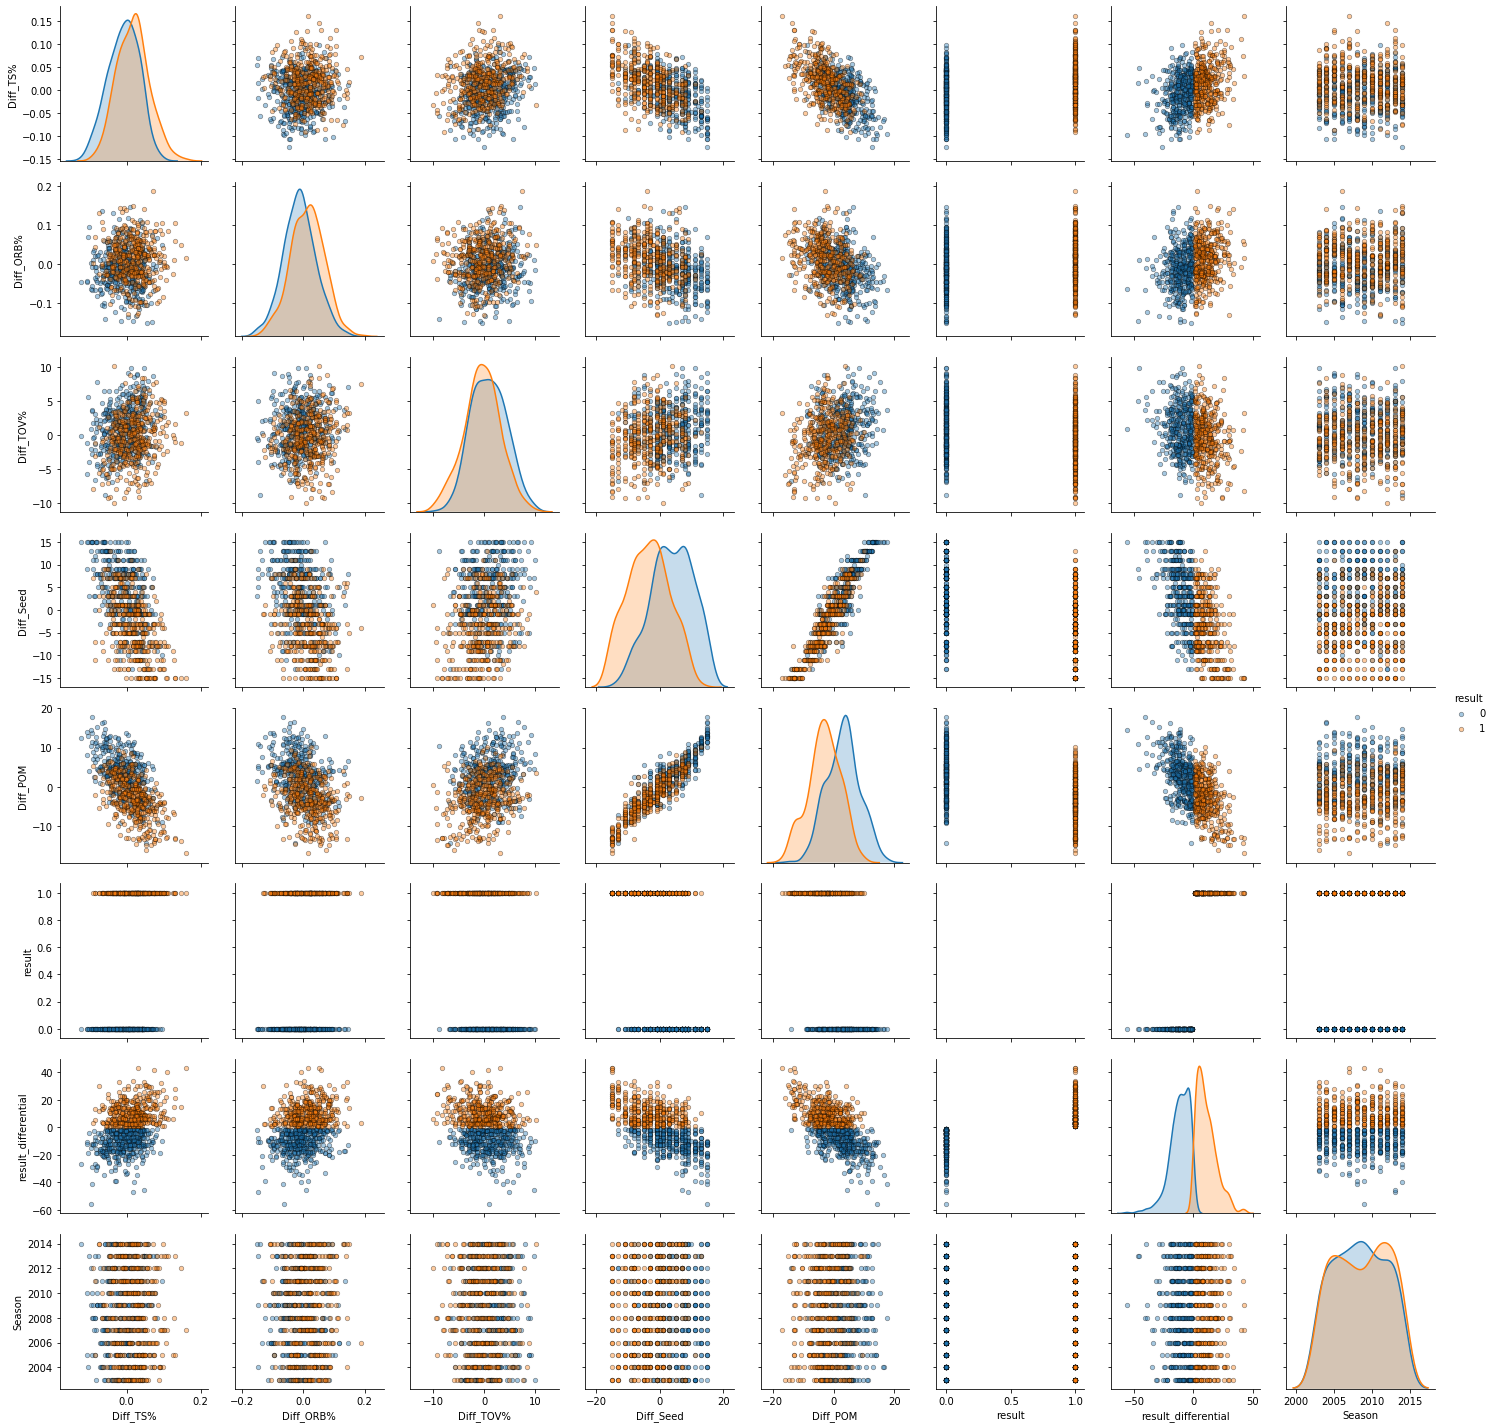

In [364]:
sns.pairplot(explore_df, hue='result', plot_kws = {'alpha': 0.4, 's': 20, 'edgecolor': 'k'})
plt.show()

In [345]:
# X = TourneyCompactResults_Train.loc[:,['Diff_Point_Diff']] #, 'Diff_TotalLossRanking', 'Diff_Best_Win', 'Diff_WinPCT']]
# Zack - another thing you can do to limit the number of variable is to only use advanced stats like TS%, ORB%, TOV% and FT/FGA. Those are called the 4 factors and they are very strong indicators of a teams ability.

x_reg = TourneyCompactResults_Train.loc[:, feature_list]
xs_reg = pd.DataFrame(preprocessing.StandardScaler().fit_transform(x_reg), columns = x_reg.columns)
y_reg = TourneyCompactResults_Train[['result_differential']]
x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(xs_reg, y_reg, test_size=0.3, stratify = TourneyCompactResults_Train['Season'])
x_train_reg

,Diff_TS%,Diff_ORB%,Diff_FT/FGA,Diff_TOV%,Diff_TLW,Diff_Seed,Diff_POM,Diff_POM_2
561,-0.519669,-0.144848,2.574783,0.488211,-0.507419,-0.701303,-0.057333,-0.094900
671,2.840253,1.933644,2.177779,0.377181,-2.595060,-2.034839,-2.150279,-1.402992
597,0.370153,-0.238295,0.493615,-0.100133,-0.019274,0.898940,0.582259,0.841898
283,-0.087037,1.244463,-1.160199,0.606228,-0.034882,0.365526,-0.870621,-1.042677
320,-2.020547,0.376706,-0.133356,-0.460928,1.140166,-0.034535,1.277065,0.646850
...,...,...,...,...,...,...,...,...
491,0.582142,-0.949164,0.084282,-1.201929,0.110172,-0.167889,-0.479202,-0.832264
201,-0.303657,-0.508335,-0.846570,-0.563021,0.722949,1.165647,0.981940,1.123250
610,0.784297,-1.267567,1.048079,1.253173,-0.816676,-1.234717,-0.901382,-0.924392
203,-0.855488,-1.243733,-0.402173,-0.650069,-0.986365,-1.768132,-1.308357,-1.191666


In [354]:
# X = TourneyCompactResults_Train.loc[:,['Diff_Point_Diff']] #, 'Diff_TotalLossRanking', 'Diff_Best_Win', 'Diff_WinPCT']]
# Zack - another thing you can do to limit the number of variable is to only use advanced stats like TS%, ORB%, TOV% and FT/FGA. Those are called the 4 factors and they are very strong indicators of a teams ability.

x = TourneyCompactResults_Train.loc[:, feature_list]
xs = pd.DataFrame(preprocessing.StandardScaler().fit_transform(x), columns = x.columns)
y = TourneyCompactResults_Train[['result']]
x_train, x_test, y_train, y_test = train_test_split(xs, y, test_size=0.3, stratify = TourneyCompactResults_Train['Season'])
x_train

,Diff_TS%,Diff_ORB%,Diff_TOV%,Diff_Seed,Diff_POM
72,0.037879,-0.851579,0.785095,-0.434596,0.384763
354,0.757871,-0.074938,1.084397,0.098818,-0.301873
687,-0.656926,1.458546,0.886101,1.032293,0.652774
621,-1.177208,0.756563,1.192168,0.898940,0.468961
344,0.660665,0.526052,0.274842,-0.167889,-0.095470
...,...,...,...,...,...
22,-0.768819,-0.699004,1.741373,1.165647,1.579546
390,-1.623376,-0.250320,1.243499,1.699061,1.623653
546,1.141042,0.377692,1.837202,-0.701303,-0.953894
196,1.782117,0.420330,0.766670,-1.501424,-1.327172


In [355]:
for alpha in [0.001,0.01,0.1,1,10,100,1000]:
    
    lr = LogisticRegression(solver='lbfgs',C=alpha,random_state=42,max_iter=500)
    score = cross_val_score(lr, xs, y.values.ravel(), cv=5, scoring='neg_log_loss')
    print(alpha, np.mean(score))
    # 0.5538911848914796

0.001 -0.6292405103601617
0.01 -0.5551946283735335
0.1 -0.5457159645597901
1 -0.547156989861442
10 -0.5474583251494903
100 -0.547491500971122
1000 -0.5474946547846005


In [340]:
lr = LogisticRegression(solver='lbfgs',C=.1,random_state=42,max_iter=500)
model = lr.fit(x_train, y_train.values.ravel())

In [341]:
ypred_xgb = model.predict_proba(x_test)
score = log_loss(y_test, ypred_xgb[:,1])
score

0.5614529210543165

In [342]:
xgb_params = {'min_child_weight':[4,5]
          ,'gamma':[i/10.0 for i in range(3,6)]
          ,'subsample':[i/10.0 for i in range(6,11)]
          ,'colsample_bytree':[i/10.0 for i in range(6,11)]
          ,'max_depth': [2,3,4]}

In [343]:
rf = RandomForestClassifier(n_estimators=100,random_state=42,min_samples_split=100)
lr = LogisticRegression(solver='lbfgs',C=0.1,random_state=42,max_iter=500)
lsvc = SVC(random_state=42,probability=True,kernel='linear')
nnb = KNeighborsClassifier(50)

estimators = [
    ('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
    ('lr',LogisticRegression(solver='lbfgs',C=0.1,random_state=42,max_iter=500)),
    ('nnb',KNeighborsClassifier(50)),
    ('lsvc',SVC(random_state=42,probability=True,kernel='linear')),
    ('xgb', RandomizedSearchCV(XGBClassifier(), xgb_params))]

clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

# xgboost = RandomizedSearchCV(XGBClassifier(), xgb_params)

model2 = clf.fit(x_train, y_train)
# xgb_model = xgboost.fit(x_train, y_train)

C:\Users\Zack\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Zack\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [344]:
ypred_xgb2 = model2.predict_proba(x_test)
score2 = log_loss(y_test, ypred_xgb2[:,1])
score2

0.574923622727889

In [150]:
ypred_xgb = model.predict_proba(x_test)

In [151]:
pd.DataFrame(x_test)

,Diff_Point_Diff,Diff_TotalLossRanking,Diff_Best_Win,Diff_WinPCT
1215,0.927802,-22.0,6.0,0.036638
1468,0.334559,369.0,17.0,0.042279
1475,0.943548,2.0,88.0,0.025202
1198,0.028325,67.0,-7.0,0.041872
1515,-5.321603,235.0,102.0,-0.102639
1594,3.238859,-1543.0,-70.0,0.108734
1808,1.188948,220.0,18.0,-0.068627
1725,20.615865,-2524.0,-57.0,0.486631
1425,-0.551411,217.0,16.0,0.056452
1383,3.792473,218.0,13.0,0.024731


In [152]:
pd.DataFrame(ypred_xgb)

,0,1
0,0.552609,0.447391
1,0.719406,0.280594
2,0.685673,0.314327
3,0.426197,0.573803
4,0.847345,0.152655
5,0.245532,0.754468
6,0.504136,0.495864
7,0.091057,0.908943
8,0.525301,0.474699
9,0.485982,0.514018


In [153]:
score = log_loss(y_test, ypred_xgb[:,1])
score

0.4981999047951672

In [154]:
raw_scaffold = data_frames['MSampleSubmissionStage1_2020'].copy()
scaffold = raw_scaffold.merge(raw_scaffold['ID'].str.split("_",expand=True), left_index=True, right_index=True)              
scaffold['Pred'] = 0
scaffold.columns = ['ID', 'Pred', 'Year', 'Team1_id', 'Team2_id']
scaffold = scaffold[['ID', 'Team1_id', 'Team2_id', 'Year', 'Pred']]
scaffold = scaffold.astype({'Year': 'int64'}).astype({'Team1_id': 'int64'}).astype({'Team2_id': 'int64'})
scaffold.dtypes

ID          object
Team1_id     int64
Team2_id     int64
Year         int64
Pred         int64
dtype: object

In [156]:
# x_test_df = scaffold.merge(TourneyCompactResults_Test, on=['ID'])

x_test_df = (scaffold
             .merge(seasonResults,left_on=['Year','Team1_id'],right_on=['Season','TeamID'],how='left')
             .drop('TeamID',axis=1)
             .merge(seasonResults,left_on=['Year','Team2_id'],right_on=['Season','TeamID'],how='left')
             .drop('TeamID',axis=1)
            )


# x_test_df

# x_test_final = x_test_df.loc[:, ['Diff_Point_Diff', 'Diff_TotalLossRanking', 'Diff_Best_Win', 'Diff_WinPCT']] # 'Score_x':'Diff_Losses']
x_test_final = x_test_df.loc[:, 'Score_x':'Diff_Losses']
test_output = xgb_model.predict_proba(x_test_final)
test_output

array([[0.97643626, 0.02356377],
       [0.9448359 , 0.0551641 ],
       [0.9529586 , 0.04704143],
       ...,
       [0.31067204, 0.68932796],
       [0.15391976, 0.84608024],
       [0.22335881, 0.7766412 ]], dtype=float32)

In [157]:
test_ids = x_test_df.loc[:,['ID']]

In [158]:
output = pd.merge(test_ids.loc[:,'ID'], pd.DataFrame(test_output[:,1]), right_index=True, left_index=True)
output.columns = ['ID', 'Pred']
output.to_csv(output_file_name+datetime.now().strftime("%Y%m%d%H%M%S")+".csv", index=False)
output

,ID,Pred
0,2015_1107_1112,0.023564
1,2015_1107_1116,0.055164
2,2015_1107_1124,0.047041
3,2015_1107_1125,0.452105
4,2015_1107_1129,0.069825
...,...,...
11385,2019_1449_1459,0.228795
11386,2019_1449_1463,0.546497
11387,2019_1458_1459,0.689328
11388,2019_1458_1463,0.846080
